In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cartopy
import cmaps
import proplot as pplt
import cnmaps
from scipy.stats import linregress
from minisom import MiniSom
from scipy.spatial import distance
import proplot as pplt

import os
os.chdir('/Users/zeqinhuang/Documents/paper/anomalous_PREC')

import warnings
warnings.filterwarnings('ignore')

In [2]:
prec_ano = xr.open_dataarray('dataset/china_daily_precipitation_summer_anomalies_1961_2018.nc')
ano_date = pd.read_csv('output/ano_dates_95th.csv',index_col=0,header=0)
ano_date = pd.to_datetime(ano_date.index,format='%Y-%m-%d')
prec_ano_95th = prec_ano.sel(time = ano_date)

# m_neurons x n_neurons SOM analysis for all anomalous precipitation dates

In [3]:
def som_analysis(data,n_neurons,m_neurons):

    lon0 = data.coords['lon']
    lat0 = data.coords['lat']

    data_stack = data.stack(z=('lon','lat'))
    data_stack_del_nan = data_stack.loc[:,data_stack['z'][~np.isnan(data_stack[0,:])]] ##### delete nan values
    data_stack = data_stack_del_nan.values
    data_stack = pd.DataFrame(data_stack)
    data_stack = data_stack.to_numpy()
 
    som = MiniSom(n_neurons, m_neurons, data_stack.shape[1], sigma=1, learning_rate=.5,
                  neighborhood_function='gaussian', random_seed=1)
    # som.pca_weights_init(data_stack)
    som.train(data_stack, 80000) # trains the SOM with 10000 iterations

    proj = pplt.Proj('pcarree', lon_0=180)
    fig, ax = pplt.subplots(ncols = m_neurons, nrows = n_neurons,share=3,wspace=(0),hspace=(0),proj = proj,width = 10)
    levels = [-30 + 3 * i for i in range(21)]
    cmap1 = cmaps.BlRe_r

    for i in range(n_neurons):
        for j in range(m_neurons):
            pattern1_flatten = som.get_weights()[i,j,:]
            pattern1 = data_stack_del_nan[0,:]
            pattern1.values = pattern1_flatten
            pattern1 = pattern1.unstack()
            pattern1 = pattern1.transpose('lat','lon')
            pattern1 = pattern1.sortby('lat',ascending=True)
            pattern1 = pattern1.sortby('lon',ascending=True)
            pattern1 = pattern1.values
            pattern1 = np.insert(pattern1,3,np.nan,axis=0)

            ax_num = i*m_neurons+j
            p1 = ax[ax_num].contourf(lon0,lat0,pattern1,levels = levels, alpha=0.75, 
                                extend = 'both',cmap=cmap1)
            ax[ax_num].format(lonlim=(lon0.min().values,lon0.max().values), latlim=(lat0.min().values,lat0.max().values),
                        coast=True, borders=True, labels=True, lonlines=20, latlines=10)

    cbar = fig.colorbar(p1,loc='b',width='0.75em',length=0.6)

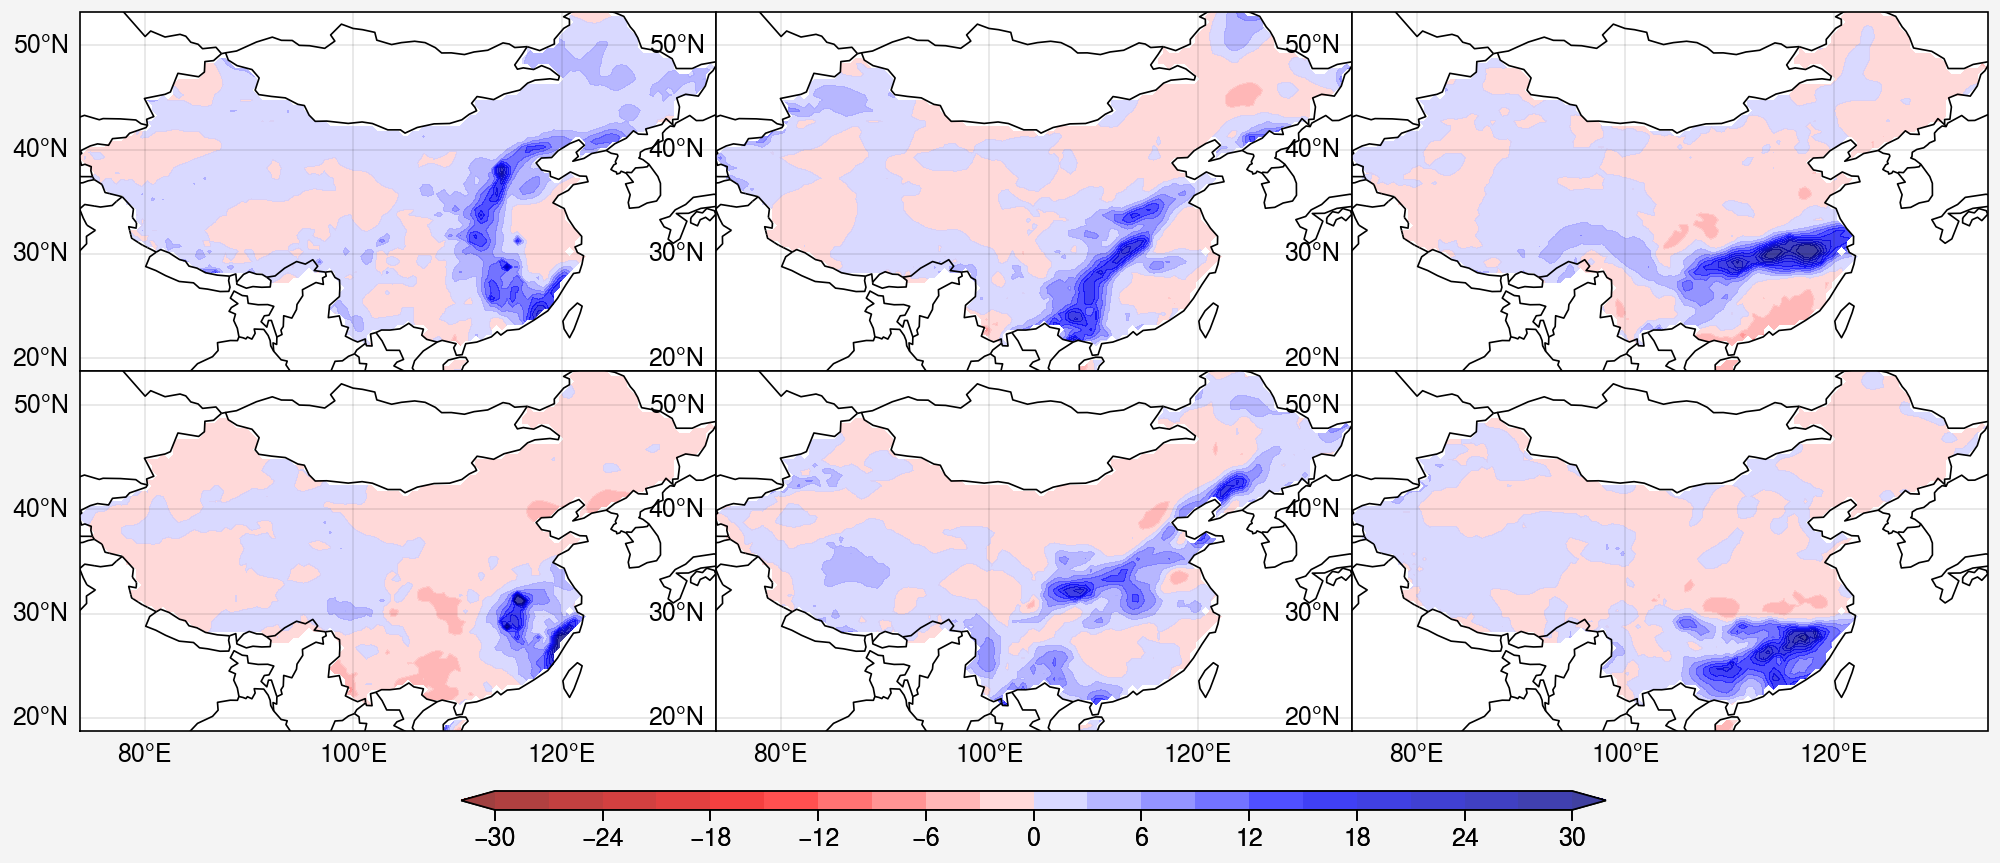

In [10]:
som_analysis(prec_ano_95th,2,3)

## SOM pattern statistics

In [11]:
def determine_winner(prec_ano_data):

    data_stack = prec_ano_data.stack(z=('lon','lat'))
    data_stack_del_nan = data_stack.loc[:,data_stack['z'][~np.isnan(data_stack[0,:])]] ##### delete nan values
    data_stack = data_stack_del_nan.values
    data_stack = pd.DataFrame(data_stack)
    data_stack = data_stack.to_numpy()
 
    som = MiniSom(2, 3, data_stack.shape[1], sigma=1, learning_rate=.5,
                  neighborhood_function='gaussian', random_seed=1)
    som.train(data_stack, 80000) 
    winners = []
   
    for i in range(len(data_stack)):
        dist1 = distance.euclidean(data_stack[i],som.get_weights()[0,0,:])
        dist2 = distance.euclidean(data_stack[i],som.get_weights()[0,1,:])
        dist3 = distance.euclidean(data_stack[i],som.get_weights()[0,2,:])
        dist4 = distance.euclidean(data_stack[i],som.get_weights()[1,0,:])
        dist5 = distance.euclidean(data_stack[i],som.get_weights()[1,1,:])
        dist6 = distance.euclidean(data_stack[i],som.get_weights()[1,2,:])
        dists = np.array([dist1,dist2,dist3,dist4,dist5,dist6])
        winner = dists.argmin()
        winners.append(winner)

    return winners

In [11]:
def determine_winner3(prec_ano_data):

    data_stack = prec_ano_data.stack(z=('lon','lat'))
    data_stack_del_nan = data_stack.loc[:,data_stack['z'][~np.isnan(data_stack[0,:])]] ##### delete nan values
    data_stack = data_stack_del_nan.values
    data_stack = pd.DataFrame(data_stack)
    data_stack = data_stack.to_numpy()
 
    som = MiniSom(2, 3, data_stack.shape[1], sigma=1, learning_rate=.5,
                  neighborhood_function='gaussian', random_seed=1)
    som.train(data_stack, 80000) 
    winners = []
   
    for i in range(len(data_stack)):
        dist1 = distance.euclidean(data_stack[i],som.get_weights()[0,0,:])
        dist2 = distance.euclidean(data_stack[i],som.get_weights()[0,1,:])
        dist3 = distance.euclidean(data_stack[i],som.get_weights()[0,2,:])
        dist4 = distance.euclidean(data_stack[i],som.get_weights()[1,0,:])
        dist5 = distance.euclidean(data_stack[i],som.get_weights()[1,1,:])
        dist6 = distance.euclidean(data_stack[i],som.get_weights()[1,2,:])
        corr1 = np.corrcoef(data_stack[i],som.get_weights()[0,0,:])[0,1]
        corr2 = np.corrcoef(data_stack[i],som.get_weights()[0,1,:])[0,1]
        corr3 = np.corrcoef(data_stack[i],som.get_weights()[0,2,:])[0,1]
        corr4 = np.corrcoef(data_stack[i],som.get_weights()[1,0,:])[0,1]
        corr5 = np.corrcoef(data_stack[i],som.get_weights()[1,1,:])[0,1]
        corr6 = np.corrcoef(data_stack[i],som.get_weights()[1,2,:])[0,1]

        dists = np.array([corr1/dist1,corr2/dist2,corr3/dist3,corr4/dist4,corr5/dist5,corr6/dist6])
        winner = dists.argmax()
        winners.append(winner)

    return winners

In [18]:
winner = determine_winner(prec_ano_95th)
winner = np.array(winner)

In [29]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import transform
from cnmaps import get_map, draw_map, clip_contours_by_map
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

# data for drawing South China sea
with open('dataset/CN_border_shapefile/CN-border-L1.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]

river = shpreader.Reader('dataset/River_shapefile/yangtze_yellow_river.shp')
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.7)

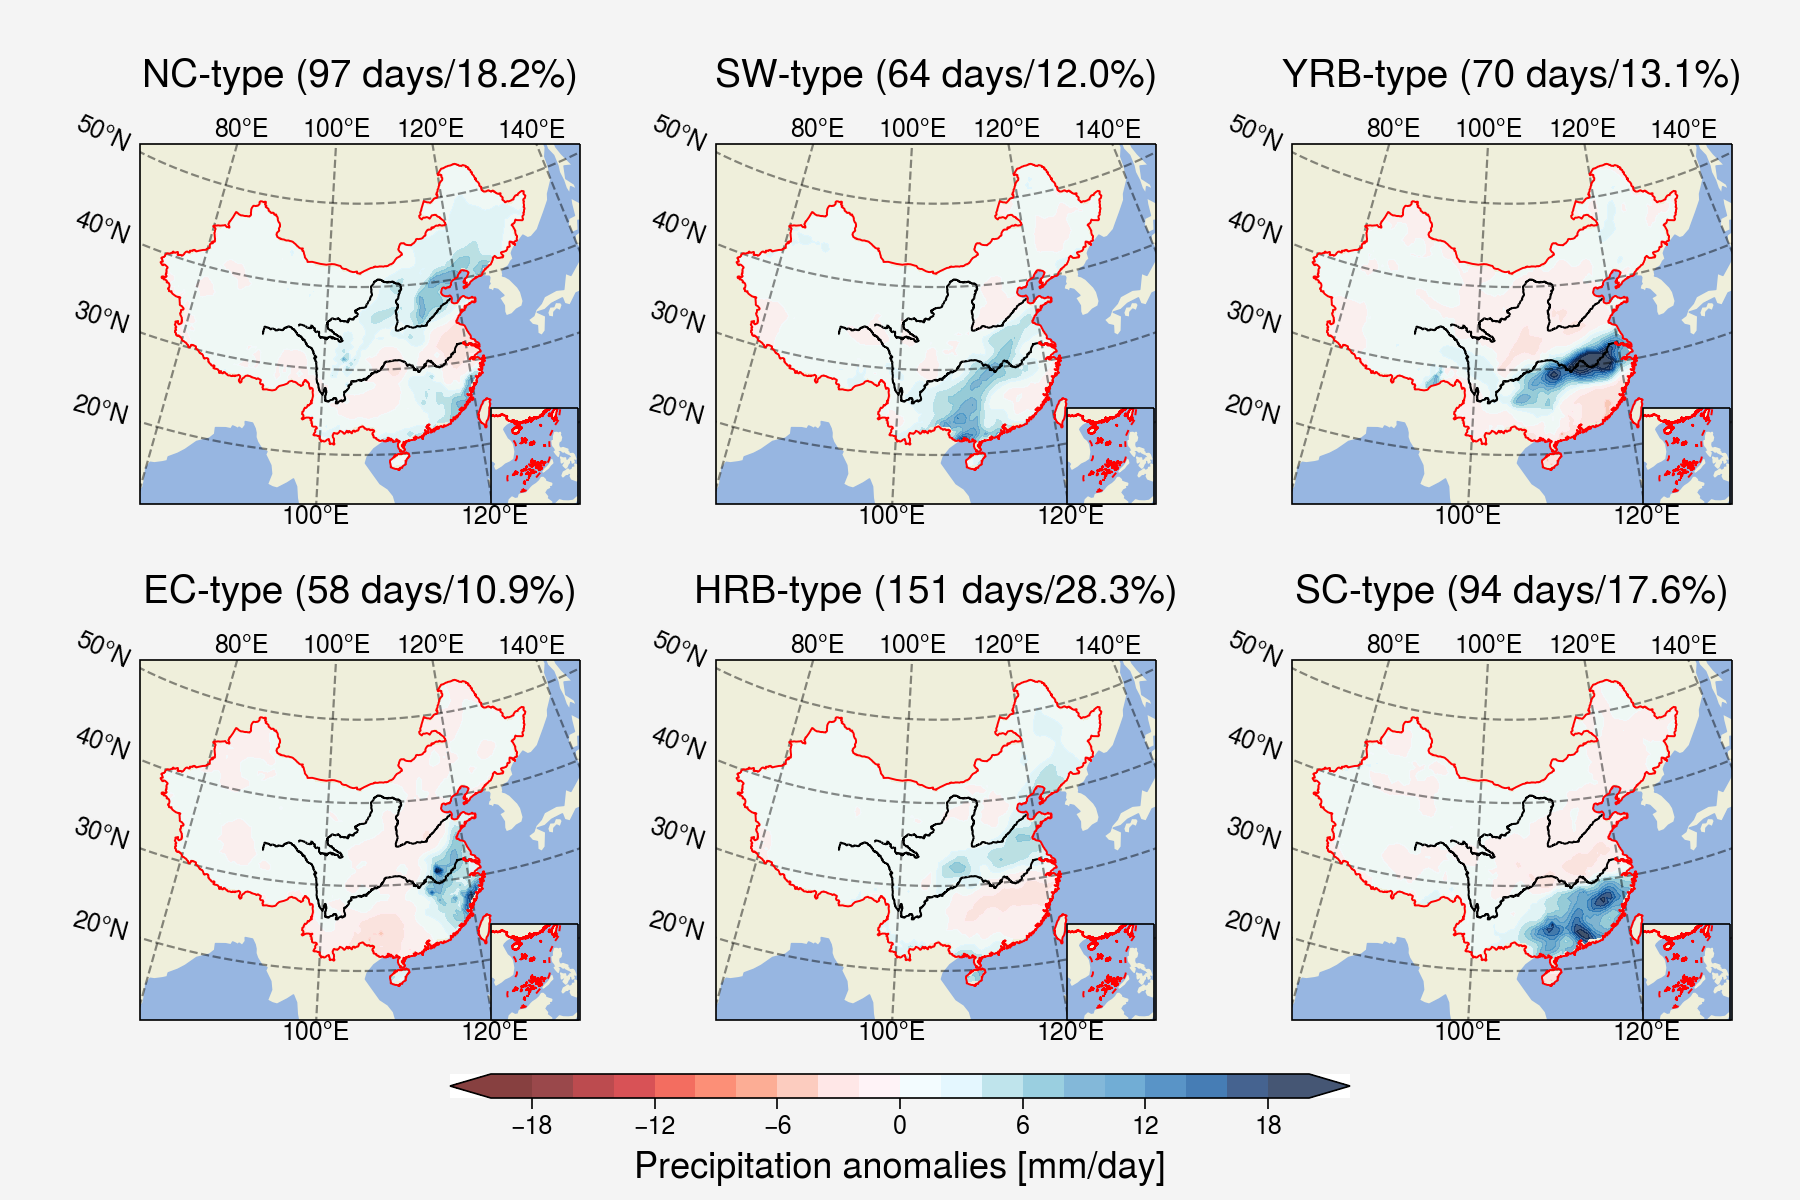

In [24]:
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
levels = [-20 + 2 * i for i in range(21)]
# cmap1 = cmaps.temp_diff_18lev_r
cmap1 = cmaps.temp_19lev_r

axes_locs = [
    [0.05,0.58,0.3,0.3],
    [0.37,0.58,0.3,0.3],
    [0.69,0.58,0.3,0.3],
    [0.05,0.15,0.3,0.3],
    [0.37,0.15,0.3,0.3],
    [0.69,0.15,0.3,0.3],
]
subaxes_locs = [
    [0.22 + 0.027, 0.58, 0.1, 0.08],
    [0.55 + 0.017, 0.58, 0.1, 0.08],
    [0.88 + 0.007, 0.58, 0.1, 0.08],
    [0.22 + 0.027, 0.15, 0.1, 0.08],
    [0.55 + 0.017, 0.15, 0.1, 0.08],
    [0.88 + 0.007, 0.15, 0.1, 0.08]
]
types = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

fig = plt.figure(figsize = (9,6))
for i in range(6):
    ax1 = fig.add_axes(axes_locs[i], projection = mapcrs)
    prec_ano_95th_winner_i = prec_ano_95th.loc[winner==i,:,:]
    prec_ano_95th_winner_i = prec_ano_95th_winner_i.mean(axis=0)
    lon = prec_ano_95th_winner_i['lon']
    lat = prec_ano_95th_winner_i['lat']
    p1 = ax1.contourf(lon,lat,prec_ano_95th_winner_i,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1, transform = ccrs.PlateCarree())

    ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
    ax1.add_feature(river_feature)
    ax1.set_extent([80, 130, 13, 55]) #.set_extent([72, 136, 18, 50])
    # ax1.set_title('SOM Pattern '+str(i + 1)+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)
    ax1.set_title(types[i]+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':14,'fontweight': 'medium'},y=1.12)

    china = get_map('中国')
    draw_map(china,color='r',linewidth=0.7)

    sub_ax = fig.add_axes(subaxes_locs[i], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))#
    sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
    sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
    for line in borders:
        sub_ax.plot(line[0::2], line[1::2], '-', color='r',transform=ccrs.Geodetic(),linewidth=0.7)
    sub_ax.set_extent([105, 125, 0, 25])

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
    gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
    gl1.right_labels = False

# set colorbar
cbar_ax = fig.add_axes([0.25, 0.085, 0.5, 0.02])
fig_cbar = fig.colorbar(p1, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Precipitation anomalies [mm/day]',fontdict={'fontsize': 13, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

fig_dir = 'figure/'
fig.savefig(fig_dir + "anomalous_precipitation_cluster_95th.pdf")

# clustered patterns distribution

In [12]:
winner = determine_winner(prec_ano_95th)
winner = np.array(winner)
winner = pd.Series(winner,index=ano_date.strftime('%Y-%m-%d'))
winner_dist = pd.DataFrame(winner)
winner_dist['Date'] = winner_dist.index
winner_dist['Year'] = winner_dist['Date'].apply(lambda x: int(x[:4]))
winner_dist['Month'] = winner_dist['Date'].apply(lambda x: int(x[5:7]))
winner_dist.index = range(len(winner_dist))
winner_dist = winner_dist.rename(columns={0:'Som_pattern'})
winner_dist['dayofyear'] = pd.to_datetime(winner_dist['Date']).dt.dayofyear
winner_dist['dayofyear'] = winner_dist['dayofyear'] - 90

In [13]:
winner_dist_with_nan = pd.DataFrame(pd.date_range('1961-01-01','2018-12-31',freq='D').strftime('%Y-%m-%d'),columns=['Date'])
winner_dist_with_nan['Year'] = winner_dist_with_nan['Date'].apply(lambda x: int(x[:4]))
winner_dist_with_nan['Month'] = winner_dist_with_nan['Date'].apply(lambda x: int(x[5:7]))
winner_dist_with_nan = winner_dist_with_nan[winner_dist_with_nan['Month'].isin([5,6,7,8,9,10])]
winner_dist_with_nan['Som_pattern'] = np.NAN
winner_dict = winner.to_dict()
winner_dist_with_nan['Som_pattern'] = winner_dist_with_nan['Date'].apply(lambda x: winner_dict.get(x))

In [14]:
winner_dist_with_nan['Date2'] = winner_dist_with_nan['Date'].apply(lambda x: pd.to_datetime(x).dayofyear - 121 if pd.to_datetime(x).is_leap_year else pd.to_datetime(x).dayofyear - 120)

In [15]:
winner_dist_with_nan_pattern = winner_dist_with_nan['Som_pattern'].to_numpy()
winner_dist_with_nan_pattern = np.reshape(winner_dist_with_nan_pattern,(-1,184))

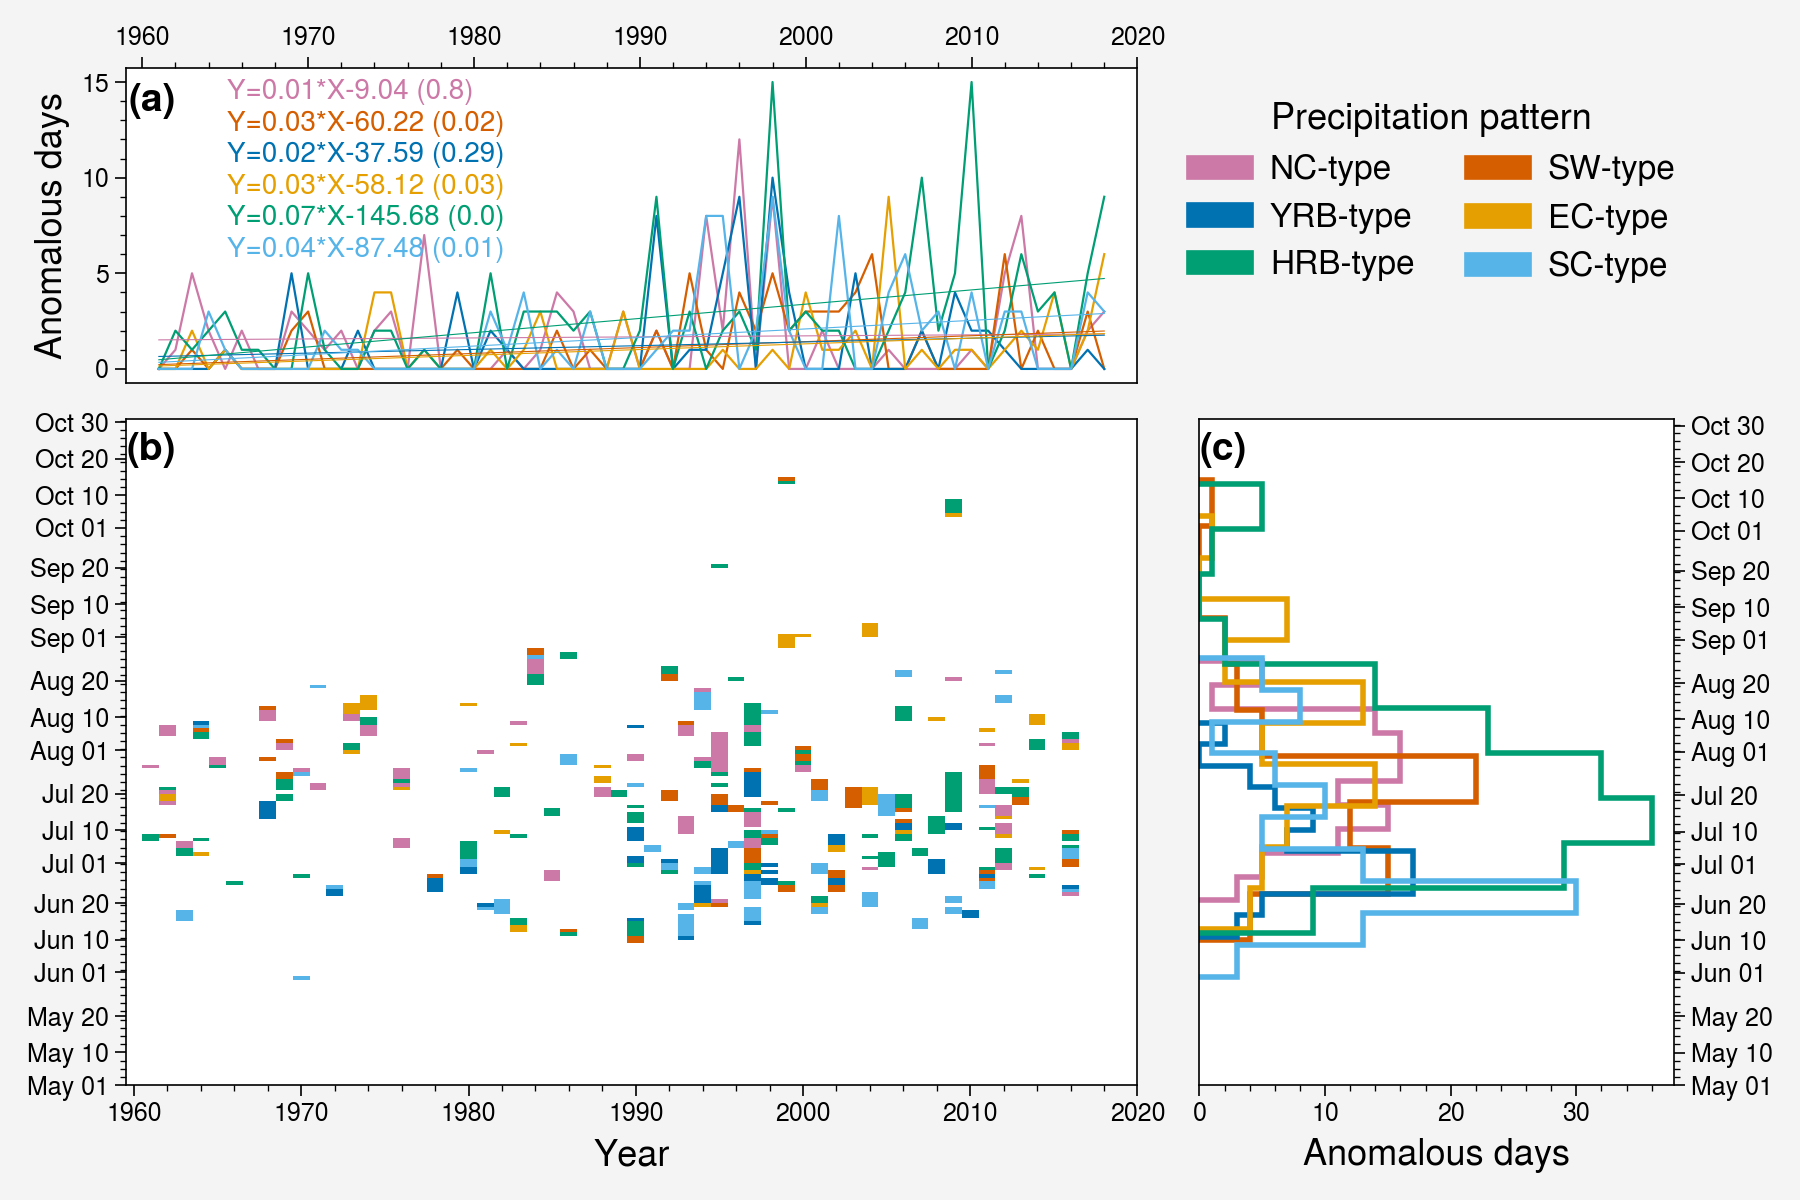

In [23]:
import cmaps
from matplotlib.gridspec import GridSpec
from matplotlib import colors as c
import matplotlib.patches as mpatches
from scipy.stats import linregress

def add_panel_label(ax, label, x = 0.05, y = 0.95):
    ax.text(x, y, label, transform=ax.transAxes,
        fontsize=14, fontweight='bold', va='top', ha='right')

# cmap = cmaps.cmocean_balance
# cmap = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
cmap = ['#CC79A7','#D55E00','#0072B2','#E69F00','#009E73','#56B4E9']
cmap_l = c.ListedColormap(cmap)
# plt.rcdefaults()
fig = plt.figure(figsize = (9,6))
gs = GridSpec(3, 3)
ax_mesh = fig.add_subplot(gs[1:3, 0:2])
ax_hist_y = fig.add_subplot(gs[0,0:2])
ax_hist_x = fig.add_subplot(gs[1:3, 2])
y, x = np.meshgrid(np.linspace(0, 183, 184), np.linspace(0, 57, 58))
c = ax_mesh.pcolormesh(x, y, winner_dist_with_nan_pattern, cmap=cmap_l, vmin=0, vmax=5)

ax_mesh.set_xlabel('Year',fontsize=13)
ax_mesh.set_yticks([0,9,19,31,40,50,61,70,80,92,101,111,123,132,142,153,162,172,182])
ax_mesh.set_yticklabels(['May 01','May 10','May 20','Jun 01','Jun 10','Jun 20','Jul 01','Jul 10','Jul 20','Aug 01','Aug 10','Aug 20','Sep 01','Sep 10','Sep 20','Oct 01','Oct 10','Oct 20','Oct 30'])
ax_mesh.set_xticks(np.linspace(0,60,61)[::10] + 0.5)
ax_mesh.set_xticklabels([1960,1970,1980,1990,2000,2010,2020])

count_pattern1 = winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==0]['Year'].value_counts().to_dict()
count_pattern2 = winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==1]['Year'].value_counts().to_dict()
count_pattern3 = winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==2]['Year'].value_counts().to_dict()
count_pattern4 = winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==3]['Year'].value_counts().to_dict()
count_pattern5 = winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==4]['Year'].value_counts().to_dict()
count_pattern6 = winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==5]['Year'].value_counts().to_dict()
count_pattern = pd.DataFrame(range(1961,2019),columns=['Year'])
count_pattern['Pattern1'] = count_pattern['Year'].apply(lambda x: count_pattern1.get(x))
count_pattern['Pattern2'] = count_pattern['Year'].apply(lambda x: count_pattern2.get(x))
count_pattern['Pattern3'] = count_pattern['Year'].apply(lambda x: count_pattern3.get(x))
count_pattern['Pattern4'] = count_pattern['Year'].apply(lambda x: count_pattern4.get(x))
count_pattern['Pattern5'] = count_pattern['Year'].apply(lambda x: count_pattern5.get(x))
count_pattern['Pattern6'] = count_pattern['Year'].apply(lambda x: count_pattern6.get(x))
count_pattern = count_pattern.fillna(0)
count_pattern.index = range(1961,2019)
del(count_pattern['Year'])
count_pattern.plot(ax=ax_hist_y,alpha=1,linewidth=0.8,legend=False,cmap=cmap_l)
for i in range(6):
    reg_func = np.poly1d(np.polyfit(count_pattern.index, count_pattern.iloc[:,i], 1))
    ax_hist_y.plot(count_pattern.index,reg_func(count_pattern.index),linewidth=0.4,color=cmap[i])
    slope, intercept, _, p, _ = linregress(count_pattern.index, count_pattern.iloc[:,i])
    if intercept > 0:
        s = 'Y=' + str(round(slope,2)) + '*X+' + str(round(intercept,2)) + ' (' + str(round(p,2)) + ')'
    else:
        s = 'Y=' + str(round(slope,2)) + '*X' + str(round(intercept,2)) + ' (' + str(round(p,2)) + ')'
    ax_hist_y.text(x = 0.1, y = 0.9-0.1*i, s = s, fontsize=10, color = cmap[i],transform=ax_hist_y.transAxes)

ax_hist_y.set_xlim((1959,2020))
ax_hist_y.xaxis.tick_top()
ax_hist_y.set_ylabel('Anomalous days',fontsize=13)
ax_hist_y.grid(False)

l1 = ax_hist_x.hist(winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==0]['Date2'], orientation = 'horizontal', color=cmap[0], alpha=1, linewidth=2, histtype='step')
l2 = ax_hist_x.hist(winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==1]['Date2'], orientation = 'horizontal', color=cmap[1], alpha=1, linewidth=2, histtype='step')
l3 = ax_hist_x.hist(winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==2]['Date2'], orientation = 'horizontal', color=cmap[2], alpha=1, linewidth=2, histtype='step')
l4 = ax_hist_x.hist(winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==3]['Date2'], orientation = 'horizontal', color=cmap[3], alpha=1, linewidth=2, histtype='step')
l5 = ax_hist_x.hist(winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==4]['Date2'], orientation = 'horizontal', color=cmap[4], alpha=1, linewidth=2, histtype='step')
l6 = ax_hist_x.hist(winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==5]['Date2'], orientation = 'horizontal', color=cmap[5], alpha=1, linewidth=2, histtype='step')
ax_hist_x.set_ylim((0,184))
ax_hist_x.set_yticks([0,9,19,31,40,50,61,70,80,92,101,111,123,132,142,153,162,172,182])
ax_hist_x.set_yticklabels(['May 01','May 10','May 20','Jun 01','Jun 10','Jun 20','Jul 01','Jul 10','Jul 20','Aug 01','Aug 10','Aug 20','Sep 01','Sep 10','Sep 20','Oct 01','Oct 10','Oct 20','Oct 30'])
ax_hist_x.yaxis.tick_right()
ax_hist_x.set_xlabel('Anomalous days',fontsize=13)
ax_hist_x.grid(False)

fig.tight_layout()
p1 = mpatches.Patch(color=cmap[0], label='NC-type')
p2 = mpatches.Patch(color=cmap[1], label='SW-type')
p3 = mpatches.Patch(color=cmap[2], label='YRB-type')
p4 = mpatches.Patch(color=cmap[3], label='EC-type')
p5 = mpatches.Patch(color=cmap[4], label='HRB-type')
p6 = mpatches.Patch(color=cmap[5], label='SC-type')

add_panel_label(ax_hist_x,'(c)', x = 0.1, y = 0.98)
add_panel_label(ax_mesh,'(b)', y = 0.98)
add_panel_label(ax_hist_y,'(a)')

fig.legend(handles=[p1, p3, p5, p2, p4, p6],loc=[0.65,0.75],ncol=2, title='Precipitation pattern',fontsize=12, title_fontsize=13,frameon=False)
fig_dir = 'figure/'
fig.savefig(fig_dir + "Distribution_anomalous_precipitation_for_different_type.pdf")

# Simultaneous composites conditioned on different anomalous precipitation types

In [25]:
from scipy import stats
## t-test 
def ttest(time_seires,pattern):
    ano_date_i = pd.to_datetime(winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==i]['Date'],format='%Y-%m-%d')
    ano_date_i.index = ano_date_i
    time_seires = pd.Series(time_seires, index=pd.date_range('1961-01-01','2018-12-31',freq='D'))
    # time_seires_ano = time_seires.sel(time=ano_date_i.index)
    time_seires_ano = time_seires.loc[ano_date_i.index]
    is_equal_var = stats.levene(time_seires_ano,time_seires).pvalue > 0.05 # if rvs1 and rvs2 have equal variance, >0.05 means their variance are equal
    pvalue = stats.ttest_ind(time_seires_ano,time_seires,equal_var=is_equal_var).pvalue
    return pvalue ## <0.05 means their mean values are significantly different

In [26]:
GPH500 = xr.open_dataarray('dataset/era5/GPH_x40-160_y-20-60_t1961-2018_level500.nc')
GPH500 = GPH500.rename({'longitude':'lon','latitude':'lat'})
GPH500_ano = GPH500.groupby('time.dayofyear') - GPH500.groupby('time.dayofyear').mean()

In [27]:
uwind850 = xr.open_dataarray('dataset/era5/uwind_x40-160_y-20-60_t1961-2018_level850.nc')
uwind850 = uwind850.rename({'longitude':'lon','latitude':'lat'})
uwind850_ano = uwind850.groupby('time.dayofyear') - uwind850.groupby('time.dayofyear').mean()

vwind850 = xr.open_dataarray('dataset/era5/vwind_x40-160_y-20-60_t1961-2018_level850.nc')
vwind850 = vwind850.rename({'longitude':'lon','latitude':'lat'})
vwind850_ano = vwind850.groupby('time.dayofyear') - vwind850.groupby('time.dayofyear').mean()

### 500 hpa GPH and 850 hpa uvwin anomalies

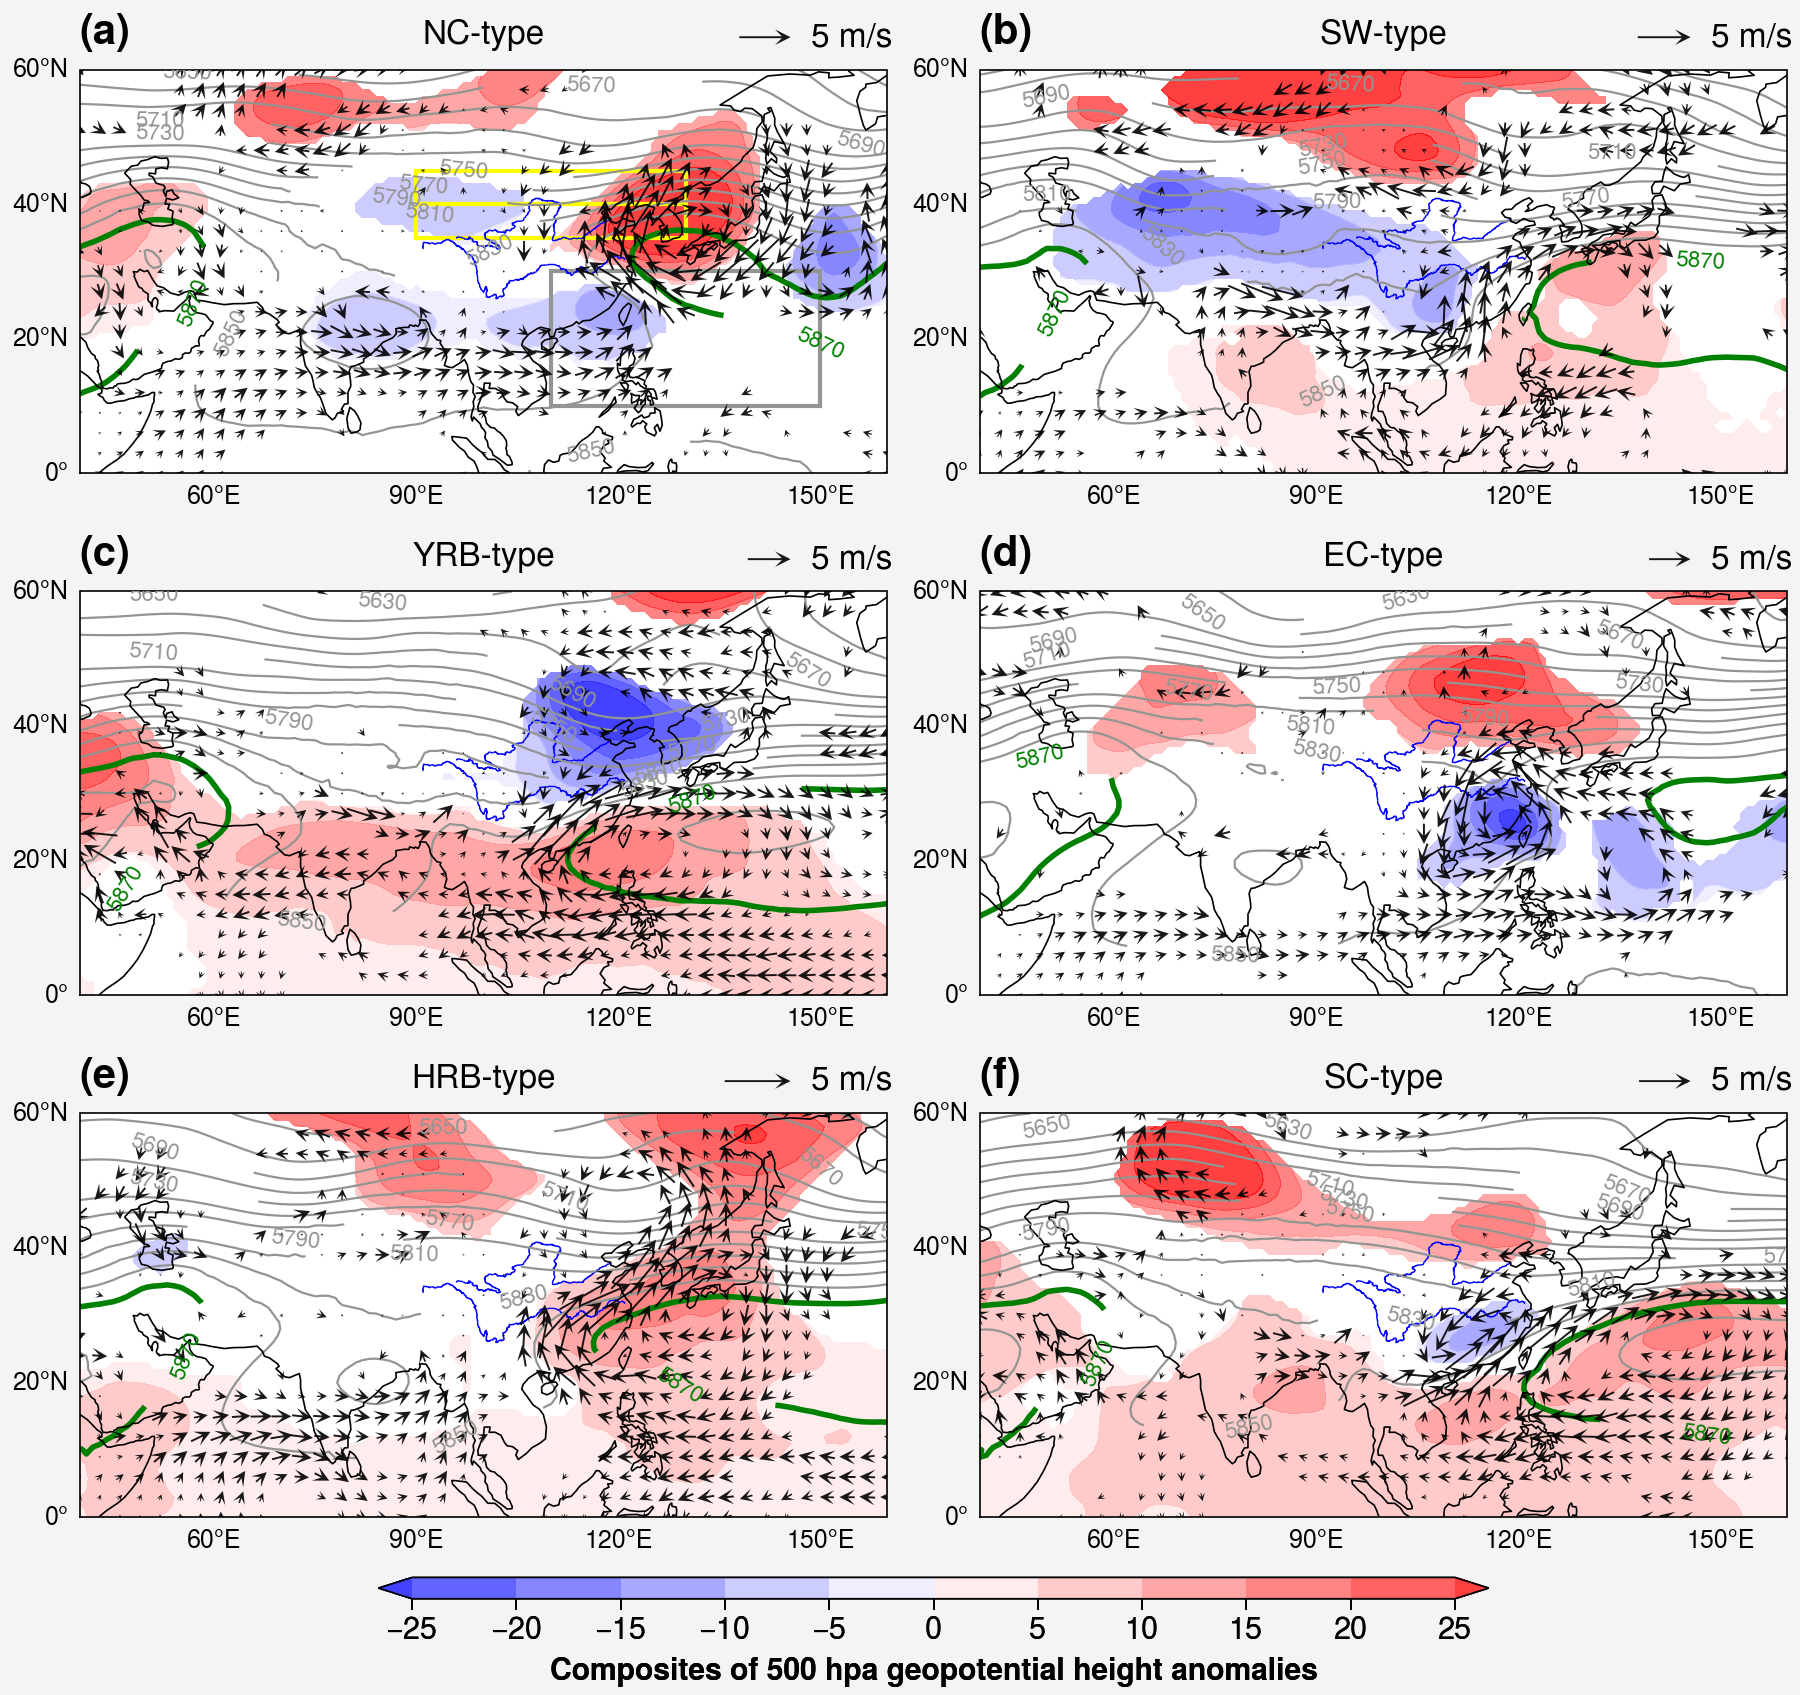

In [31]:
proj = pplt.Proj('pcarree', lon_0=180)
fig, ax = pplt.subplots(ncols=2,nrows=3,width = 9,proj=proj,share=False)

lon = GPH500_ano.coords['lon']
lat = GPH500_ano.coords['lat']
levels_GPH = [i for i in np.linspace(-25,25,11)]
# cmap1 = cmaps.BlRe
cmap1 = cmaps.MPL_bwr
lon_min = 40
lon_max = 160
lat_min = -20
lat_max = 60

title_list = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

for i in range(6):
    ano_date_i = pd.to_datetime(winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==i]['Date'],format='%Y-%m-%d')
    ano_date_i.index = ano_date_i
    GPH500_ano_i = GPH500_ano.sel(time=ano_date_i.index)
    GPH500_ano_i_mean = GPH500_ano_i.mean(axis=0)
    GPH500_i = GPH500.sel(time=ano_date_i.index)
    GPH500_i_mean = GPH500_i.mean(axis=0)
    uwind850_ano_i = uwind850_ano.sel(time=ano_date_i.index)
    uwind850_ano_i_mean = uwind850_ano_i.mean(axis=0)
    vwind850_ano_i = vwind850_ano.sel(time=ano_date_i.index)
    vwind850_ano_i_mean = vwind850_ano_i.mean(axis=0)

    sig_GPH500 = xr.apply_ufunc(   ## determine the significance by t-test
        ttest,
        GPH500_ano,
        vectorize=True,
        dask='parallelized', 
        input_core_dims=[['time']],
        output_core_dims=[[]],
        # output_dtypes=[float],
        kwargs={'pattern':i}
        )
    sig_GPH500 = sig_GPH500 < 0.05
    GPH500_ano_i_mean = GPH500_ano_i_mean * sig_GPH500
    GPH500_ano_i_mean = np.where(GPH500_ano_i_mean==0,np.nan,GPH500_ano_i_mean)

    sig_uwind = xr.apply_ufunc(   ## determine the significance by t-test
        ttest,
        uwind850_ano,
        vectorize=True,
        dask='parallelized', 
        input_core_dims=[['time']],
        output_core_dims=[[]],
        kwargs={'pattern':i}
        )
    sig_vwind = xr.apply_ufunc(   ## determine the significance by t-test
        ttest,
        vwind850_ano,
        vectorize=True,
        dask='parallelized', 
        input_core_dims=[['time']],
        output_core_dims=[[]],
        kwargs={'pattern':i}
        )
    sig_uwind = sig_uwind < 0.05
    sig_vwind = sig_vwind < 0.05
    sig_uvwind = sig_uwind + sig_vwind
    sig_uvwind = sig_uvwind > 0
    uwind850_ano_i_mean = uwind850_ano_i_mean * sig_uvwind
    uwind850_ano_i_mean = np.where(uwind850_ano_i_mean==0,np.nan,uwind850_ano_i_mean)
    vwind850_ano_i_mean = vwind850_ano_i_mean * sig_uvwind
    vwind850_ano_i_mean = np.where(vwind850_ano_i_mean==0,np.nan,vwind850_ano_i_mean)

    river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.5)
    p1 = ax[i].contourf(lon,lat,GPH500_ano_i_mean,levels=levels_GPH,alpha=0.75,extend='both',cmap=cmap1,zorder=1)
    contours = ax[i].contour(lon,lat,GPH500_i_mean, levels = [5630,5650,5670,5690,5710,5730,5750,5770,5790,5810,5830,5850,5890], colors=('gray',),linestyles=('-',),linewidths=(0.8,),zorder=2)
    plt.clabel(contours, inline=True, fontsize=8)
    contour_5870 = ax[i].contour(lon,lat,GPH500_i_mean,levels=[5870],colors=('green',),linestyles=('-',),linewidths=(2,),zorder=2)
    plt.clabel(contour_5870, inline=True, fontsize=8)
    p2 = ax[i].quiver(
        lon[::3], lat[::3], uwind850_ano_i_mean[::3,::3], vwind850_ano_i_mean[::3,::3],color='black',
        pivot='middle',alpha=0.9,headlength=8,headwidth = 8,minshaft=1,zorder=3)

    ax[i].format(coast=True, lonlim=(lon_min,lon_max), latlim=(0,lat_max),labels=True, lonlines=30, latlines=20)
    ax[i].add_feature(river_feature)
    ax[i].set_title(title_list[i],fontdict={'fontsize':12})

    qk = ax[i].quiverkey(p2, 0.88, 1.08, 5, r'5 m/s', labelpos='E', fontproperties={'size':12},) # $5  \frac{m}{s}$,  #coordinates='figure'
    if i==0:
        ax[i].add_patch(plt.Rectangle((-70,10),width=40,height=20,fc='none',color='gray',linewidth=1.5))
        ax[i].add_patch(plt.Rectangle((-90,35),width=40,height=5,fc='none',color='yellow',linewidth=1.5))
        ax[i].add_patch(plt.Rectangle((-90,40),width=40,height=5,fc='none',color='yellow',linewidth=1.5))

ax.format(abc = '(a)', abcloc='l', abcsize=15,)
cbar = fig.colorbar(p1,loc='b',width='0.85em',length=0.65)
cbar.set_label(label='Composites of 500 hpa geopotential height anomalies',size='large', weight='bold')
cbar.ax.tick_params(labelsize=11)  

fig_dir = 'figure/'
fig.savefig(fig_dir + "500hpa_GPH_and_850hpa_uvwind_anomalies.pdf")

In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

# data for drawing South China sea
with open('dataset/CN_border_shapefile/CN-border-L1.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]

river = shpreader.Reader('dataset/River_shapefile/yangtze_yellow_river.shp')
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.7)

### integrated water vapour flux and divergence
integrated water vapour flux unit: era5: kg m-1 s-1
divergence unit: era5: kg m-2

In [52]:
viwv_v = xr.open_dataarray('dataset/era5/viwvn_x40-160_y-20-60_t1961-2018.nc')
viwv_u = xr.open_dataarray('dataset/era5/wiwve_x40-160_y-20-60_t1961-2018.nc')
viwv_v = viwv_v.rename({'longitude':'lon','latitude':'lat'})
viwv_u = viwv_u.rename({'longitude':'lon','latitude':'lat'})
viwv_v_ano = viwv_v.groupby('time.dayofyear') - viwv_v.groupby('time.dayofyear').mean()
viwv_u_ano = viwv_u.groupby('time.dayofyear') - viwv_u.groupby('time.dayofyear').mean()

In [53]:
vimd = xr.open_dataarray('dataset/era5/vimd_x40-160_y-20-60_t1961-2018.nc')
vimd = vimd.rename({'longitude':'lon','latitude':'lat'})
vimd_ano = vimd.groupby('time.dayofyear') - vimd.groupby('time.dayofyear').mean()

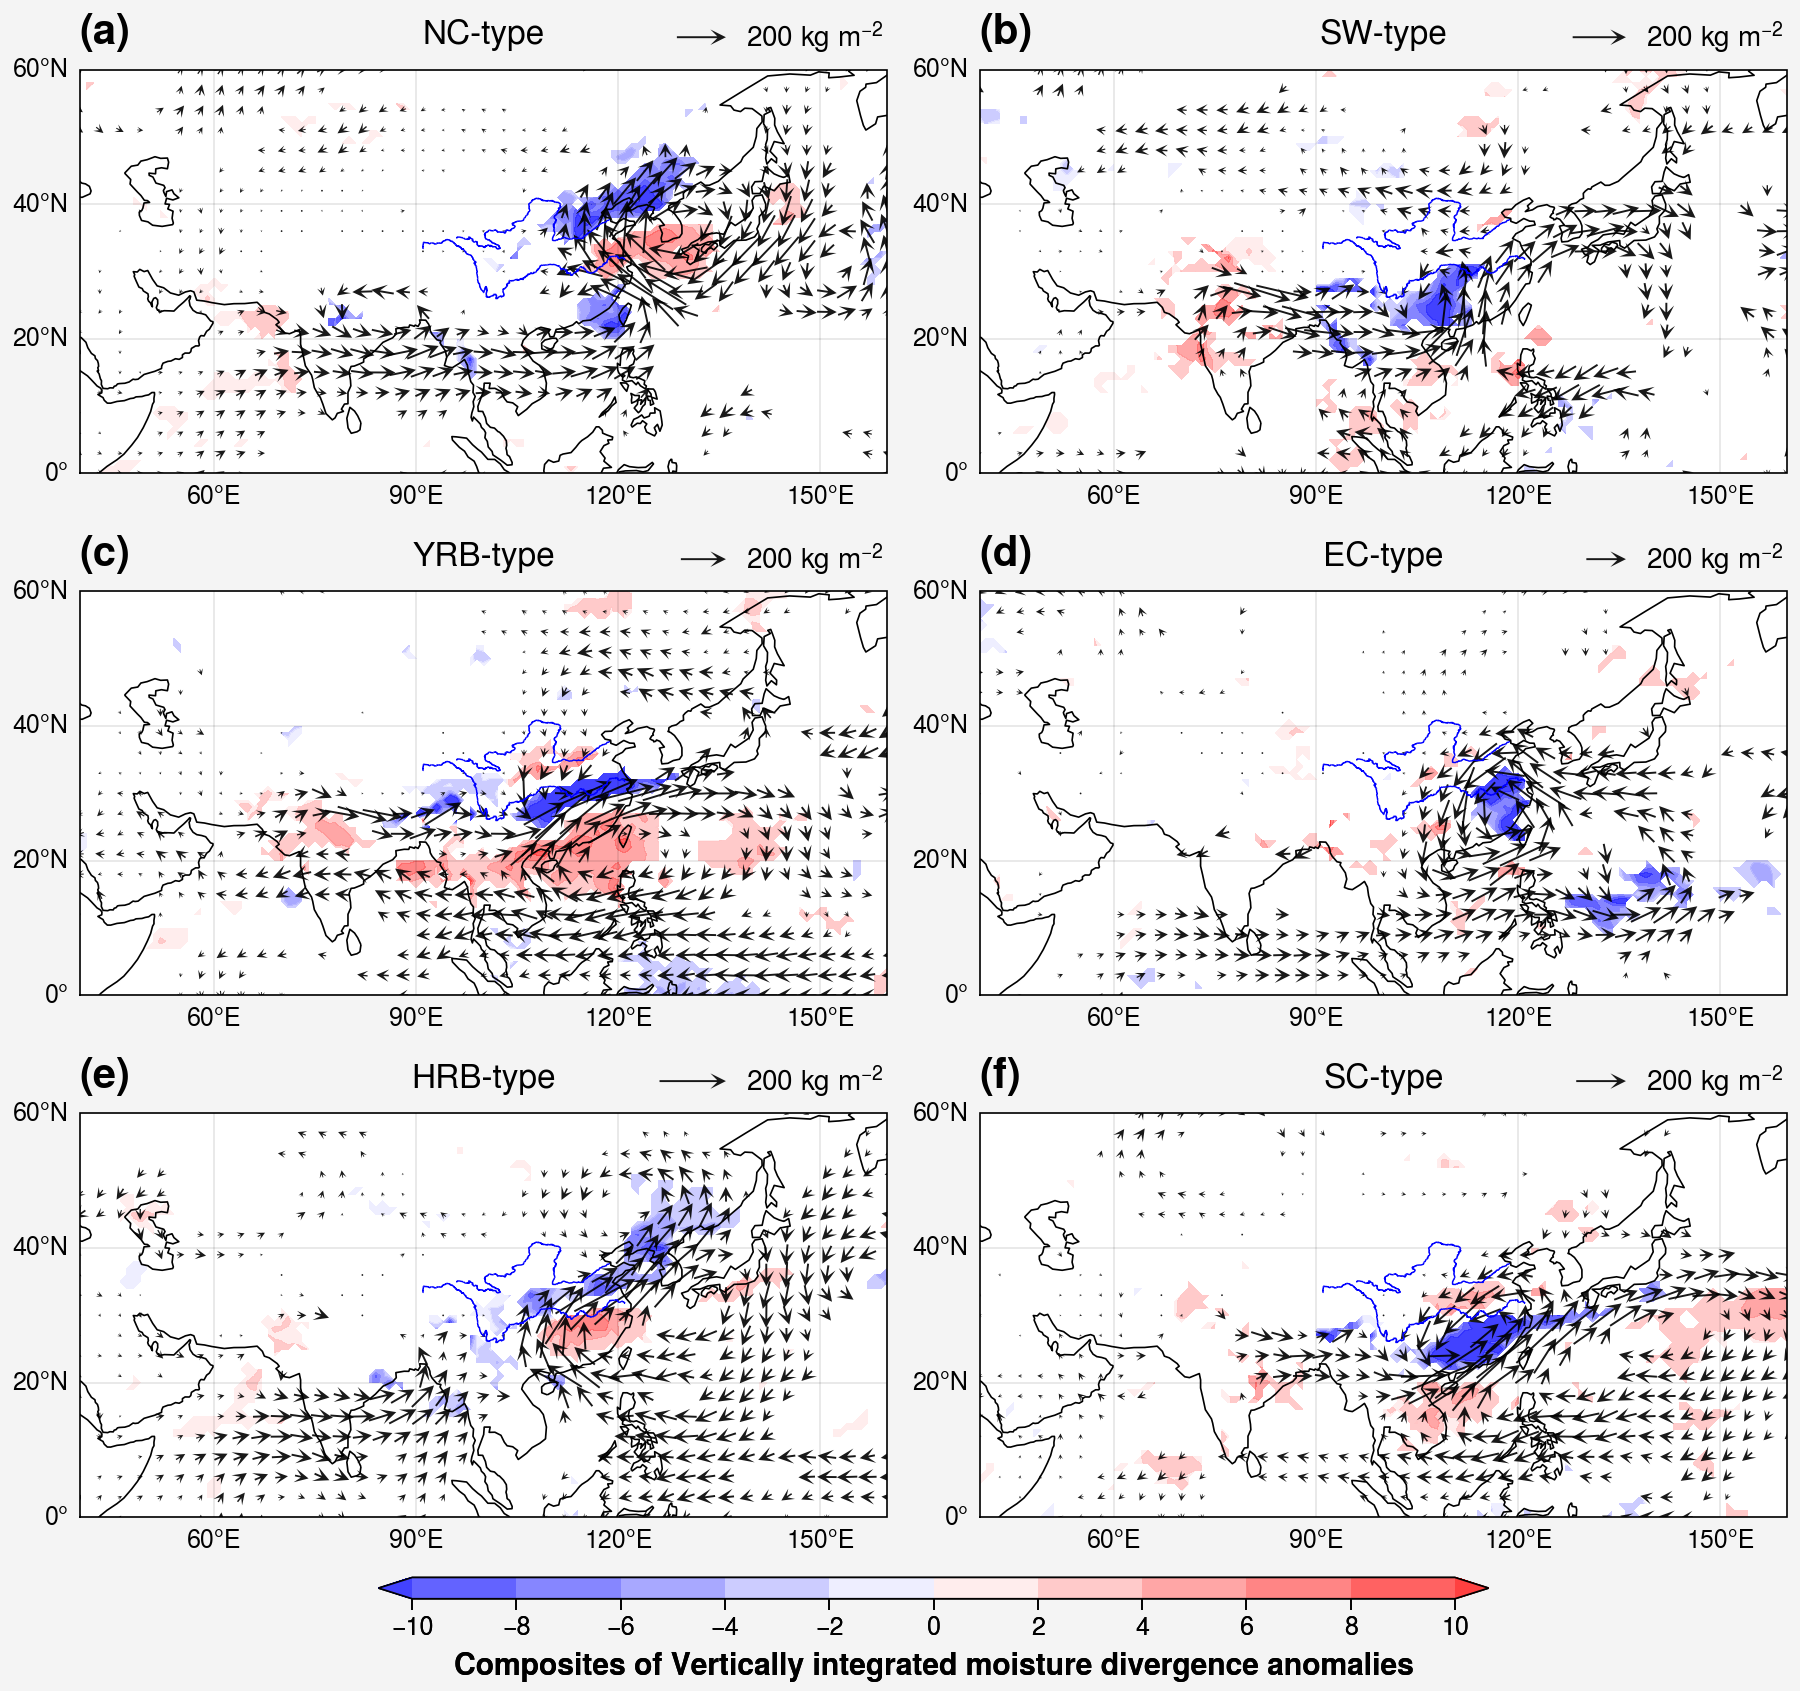

In [54]:
proj = pplt.Proj('pcarree', lon_0=180)
fig, ax = pplt.subplots(ncols=2,nrows=3,width = 9,proj=proj,share=False)

lon = vimd_ano.coords['lon']
lat = vimd_ano.coords['lat']
levels_GPH = [i for i in np.linspace(-10,10,11)]
cmap1 = cmaps.MPL_bwr
lon_min = 40
lon_max = 160
lat_min = -20
lat_max = 60

title_list = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

for i in range(6):
    ano_date_i = pd.to_datetime(winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==i]['Date'],format='%Y-%m-%d')
    ano_date_i.index = ano_date_i
    vimd_ano_i = vimd_ano.sel(time=ano_date_i.index)
    vimd_ano_i_mean = vimd_ano_i.mean(axis=0)
    vimd_i = vimd.sel(time=ano_date_i.index)
    vimd_i_mean = vimd_i.mean(axis=0)
    viwv_u_ano_i = viwv_u_ano.sel(time=ano_date_i.index)
    viwv_u_ano_i_mean = viwv_u_ano_i.mean(axis=0)
    viwv_v_ano_i = viwv_v_ano.sel(time=ano_date_i.index)
    viwv_v_ano_i_mean = viwv_v_ano_i.mean(axis=0)

    sig_vimd = xr.apply_ufunc(   ## determine the significance by t-test
        ttest,
        vimd_ano,
        vectorize=True,
        dask='parallelized', 
        input_core_dims=[['time']],
        output_core_dims=[[]],
        # output_dtypes=[float],
        kwargs={'pattern':i}
        )
    sig_vimd = sig_vimd < 0.05
    vimd_ano_i_mean = vimd_ano_i_mean * sig_vimd
    vimd_ano_i_mean = np.where(vimd_ano_i_mean==0,np.nan,vimd_ano_i_mean)

    sig_viwv_u = xr.apply_ufunc(   ## determine the significance by t-test
        ttest,
        viwv_u_ano,
        vectorize=True,
        dask='parallelized', 
        input_core_dims=[['time']],
        output_core_dims=[[]],
        kwargs={'pattern':i}
        )
    sig_viwv_v = xr.apply_ufunc(   ## determine the significance by t-test
        ttest,
        viwv_v_ano,
        vectorize=True,
        dask='parallelized', 
        input_core_dims=[['time']],
        output_core_dims=[[]],
        kwargs={'pattern':i}
        )
    sig_viwv_u = sig_viwv_u < 0.05
    sig_viwv_v = sig_viwv_v < 0.05
    sig_uviwv_v = sig_viwv_u + sig_viwv_v
    sig_uviwv_v = sig_uviwv_v > 0
    viwv_u_ano_i_mean = viwv_u_ano_i_mean * sig_uviwv_v
    viwv_u_ano_i_mean = np.where(viwv_u_ano_i_mean==0,np.nan,viwv_u_ano_i_mean)
    viwv_v_ano_i_mean = viwv_v_ano_i_mean * sig_uviwv_v
    viwv_v_ano_i_mean = np.where(viwv_v_ano_i_mean==0,np.nan,viwv_v_ano_i_mean)

    river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.5)
    p1 = ax[i].contourf(lon,lat,vimd_ano_i_mean,levels=levels_GPH,alpha=0.75,extend='both',cmap=cmap1)
    p2 = ax[i].quiver(
        lon[::3], lat[::3], viwv_u_ano_i_mean[::3,::3], viwv_v_ano_i_mean[::3,::3],color='black',
        pivot='middle',alpha=0.9,headlength=8,headwidth = 8,minshaft=1)

    ax[i].format(coast=True, lonlim=(lon_min,lon_max), latlim=(0,lat_max),labels=True, lonlines=30, latlines=20)
    ax[i].add_feature(river_feature)
    ax[i].set_title(title_list[i],fontdict={'fontsize':12})

    qk = ax[i].quiverkey(p2, 0.8, 1.08, 200, r'200 kg $m^{-2}$', labelpos='E', fontproperties={'size':10},) # $5  \frac{m}{s}$,  #coordinates='figure'
ax.format(abc = '(a)', abcloc='l', abcsize=15,)
cbar = fig.colorbar(p1,loc='b',width='0.85em',length=0.65)  
cbar.set_label(label='Composites of Vertically integrated moisture divergence anomalies',size='large',weight='bold') 

fig_dir = 'figure/'
fig.savefig(fig_dir + "vertically_integrated_moisture_anomalies.pdf")

### sea surface temperature and OLR (out longwave radiation) contour
The thermal (also known as terrestrial or longwave) radiation emitted to space at the top of the atmosphere is commonly known as the Outgoing Longwave Radiation (OLR). The top net thermal radiation (this parameter) is equal to the negative of OLR. This parameter is accumulated over a particular time period which depends on the data extracted. For the reanalysis, the accumulation period is over the 1 hour ending at the validity date and time. For the ensemble members, ensemble mean and ensemble spread, the accumulation period is over the 3 hours ending at the validity date and time. The units are joules per square metre (J m-2 ). To convert to watts per square metre (W m-2 ), the accumulated values should be divided by the accumulation period expressed in seconds. The ECMWF convention for vertical fluxes is positive downwards. (https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)

In [55]:
sst = xr.open_dataarray('dataset/era5/sst_x40-160_y-20-60_t1961-2018.nc')
ttr = xr.open_dataarray('dataset/era5/ttr_x40-160_y-20-60_t1961-2018.nc')
sst = sst.rename({'longitude':'lon','latitude':'lat'})
ttr = ttr.rename({'longitude':'lon','latitude':'lat'})
olr = - ttr / 86400
sst_ano = sst.groupby('time.dayofyear') - sst.groupby('time.dayofyear').mean()
olr_ano = olr.groupby('time.dayofyear') - olr.groupby('time.dayofyear').mean()

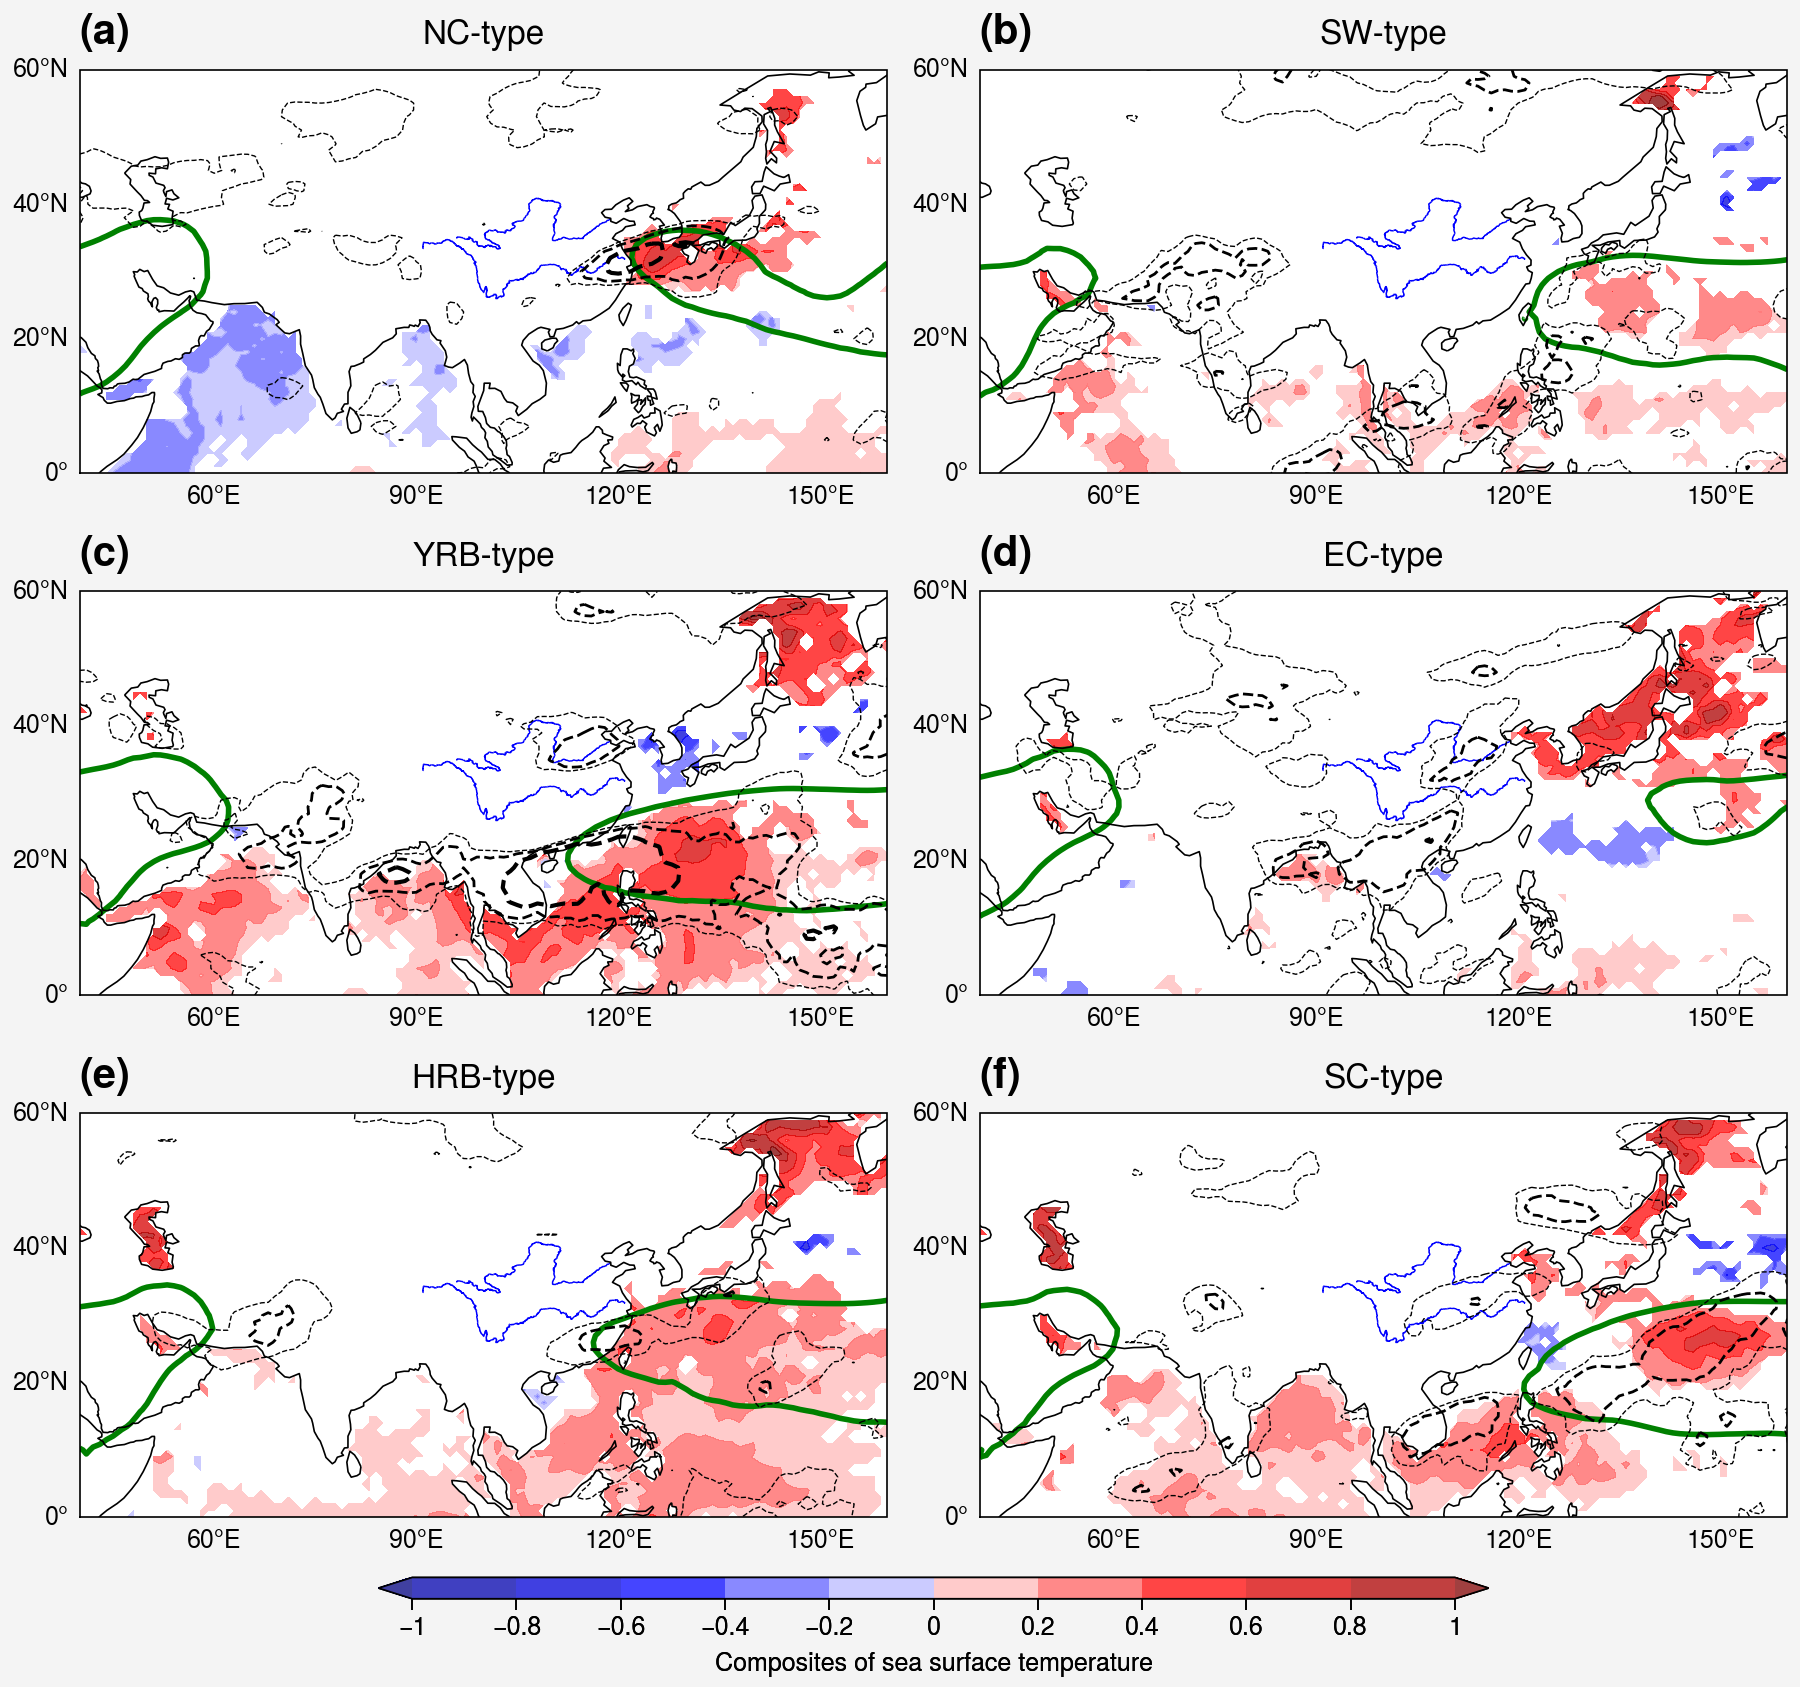

In [117]:
proj = pplt.Proj('pcarree', lon_0=180)
fig, ax = pplt.subplots(ncols=2,nrows=3,width = 9,proj=proj,share=False)

lon = GPH500_ano.coords['lon']
lat = GPH500_ano.coords['lat']
levels_sst = [i for i in np.linspace(-1,1,11)]
cmap1 = cmaps.BlRe
# cmap1 = cmaps.MPL_bwr
lon_min = 40
lon_max = 160
lat_min = -20
lat_max = 60

title_list = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

for i in range(6):
    ano_date_i = pd.to_datetime(winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==i]['Date'],format='%Y-%m-%d')
    ano_date_i.index = ano_date_i
    sst_ano_i = sst_ano.sel(time=ano_date_i.index)
    sst_ano_i_mean = sst_ano_i.mean(axis=0)
    olr_ano_i = olr_ano.sel(time=ano_date_i.index)
    olr_ano_i_mean = olr_ano_i.mean(axis=0)

    GPH500_i = GPH500.sel(time=ano_date_i.index)
    GPH500_i_mean = GPH500_i.mean(axis=0)

    sig_sst = xr.apply_ufunc(   ## determine the significance by t-test
        ttest,
        sst_ano,
        vectorize=True,
        dask='parallelized', 
        input_core_dims=[['time']],
        output_core_dims=[[]],
        kwargs={'pattern':i}
        )

    sig_sst = sig_sst < 0.05
    sst_ano_i_mean = sst_ano_i_mean * sig_sst
    sst_ano_i_mean = np.where(sst_ano_i_mean==0,np.nan,sst_ano_i_mean)

    river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.5)
    p1 = ax[i].contourf(lon,lat,sst_ano_i_mean,levels=levels_sst,alpha=0.75,extend='both',cmap=cmap1)
    ax[i].contour(lon,lat,GPH500_i_mean,levels=[5870],colors=('green',),linestyles=('-',),linewidths=(2,))
    ax[i].contour(lon,lat,olr_ano_i_mean,levels=[5],colors=('black',),linestyles=('--',),linewidths=(0.5,))
    ax[i].contour(lon,lat,olr_ano_i_mean,levels=[10],colors=('black',),linestyles=('--',),linewidths=(1,))
    ax[i].contour(lon,lat,olr_ano_i_mean,levels=[20],colors=('black',),linestyles=('--',),linewidths=(1.5,))

    ax[i].format(coast=True, lonlim=(lon_min,lon_max), latlim=(0,lat_max),labels=True, lonlines=30, latlines=20)
    ax[i].add_feature(river_feature)
    ax[i].set_title(title_list[i],fontdict={'fontsize':12})

ax.format(abc = '(a)', abcloc='l', abcsize=15,)
cbar = fig.colorbar(p1,loc='b',width='0.85em',length=0.65,)   
cbar.set_label(label='Composites of sea surface temperature',size='large',weight='bold')
fig_dir = 'figure/'
fig.savefig(fig_dir + "sea_surface_temperature_anomalies.pdf")

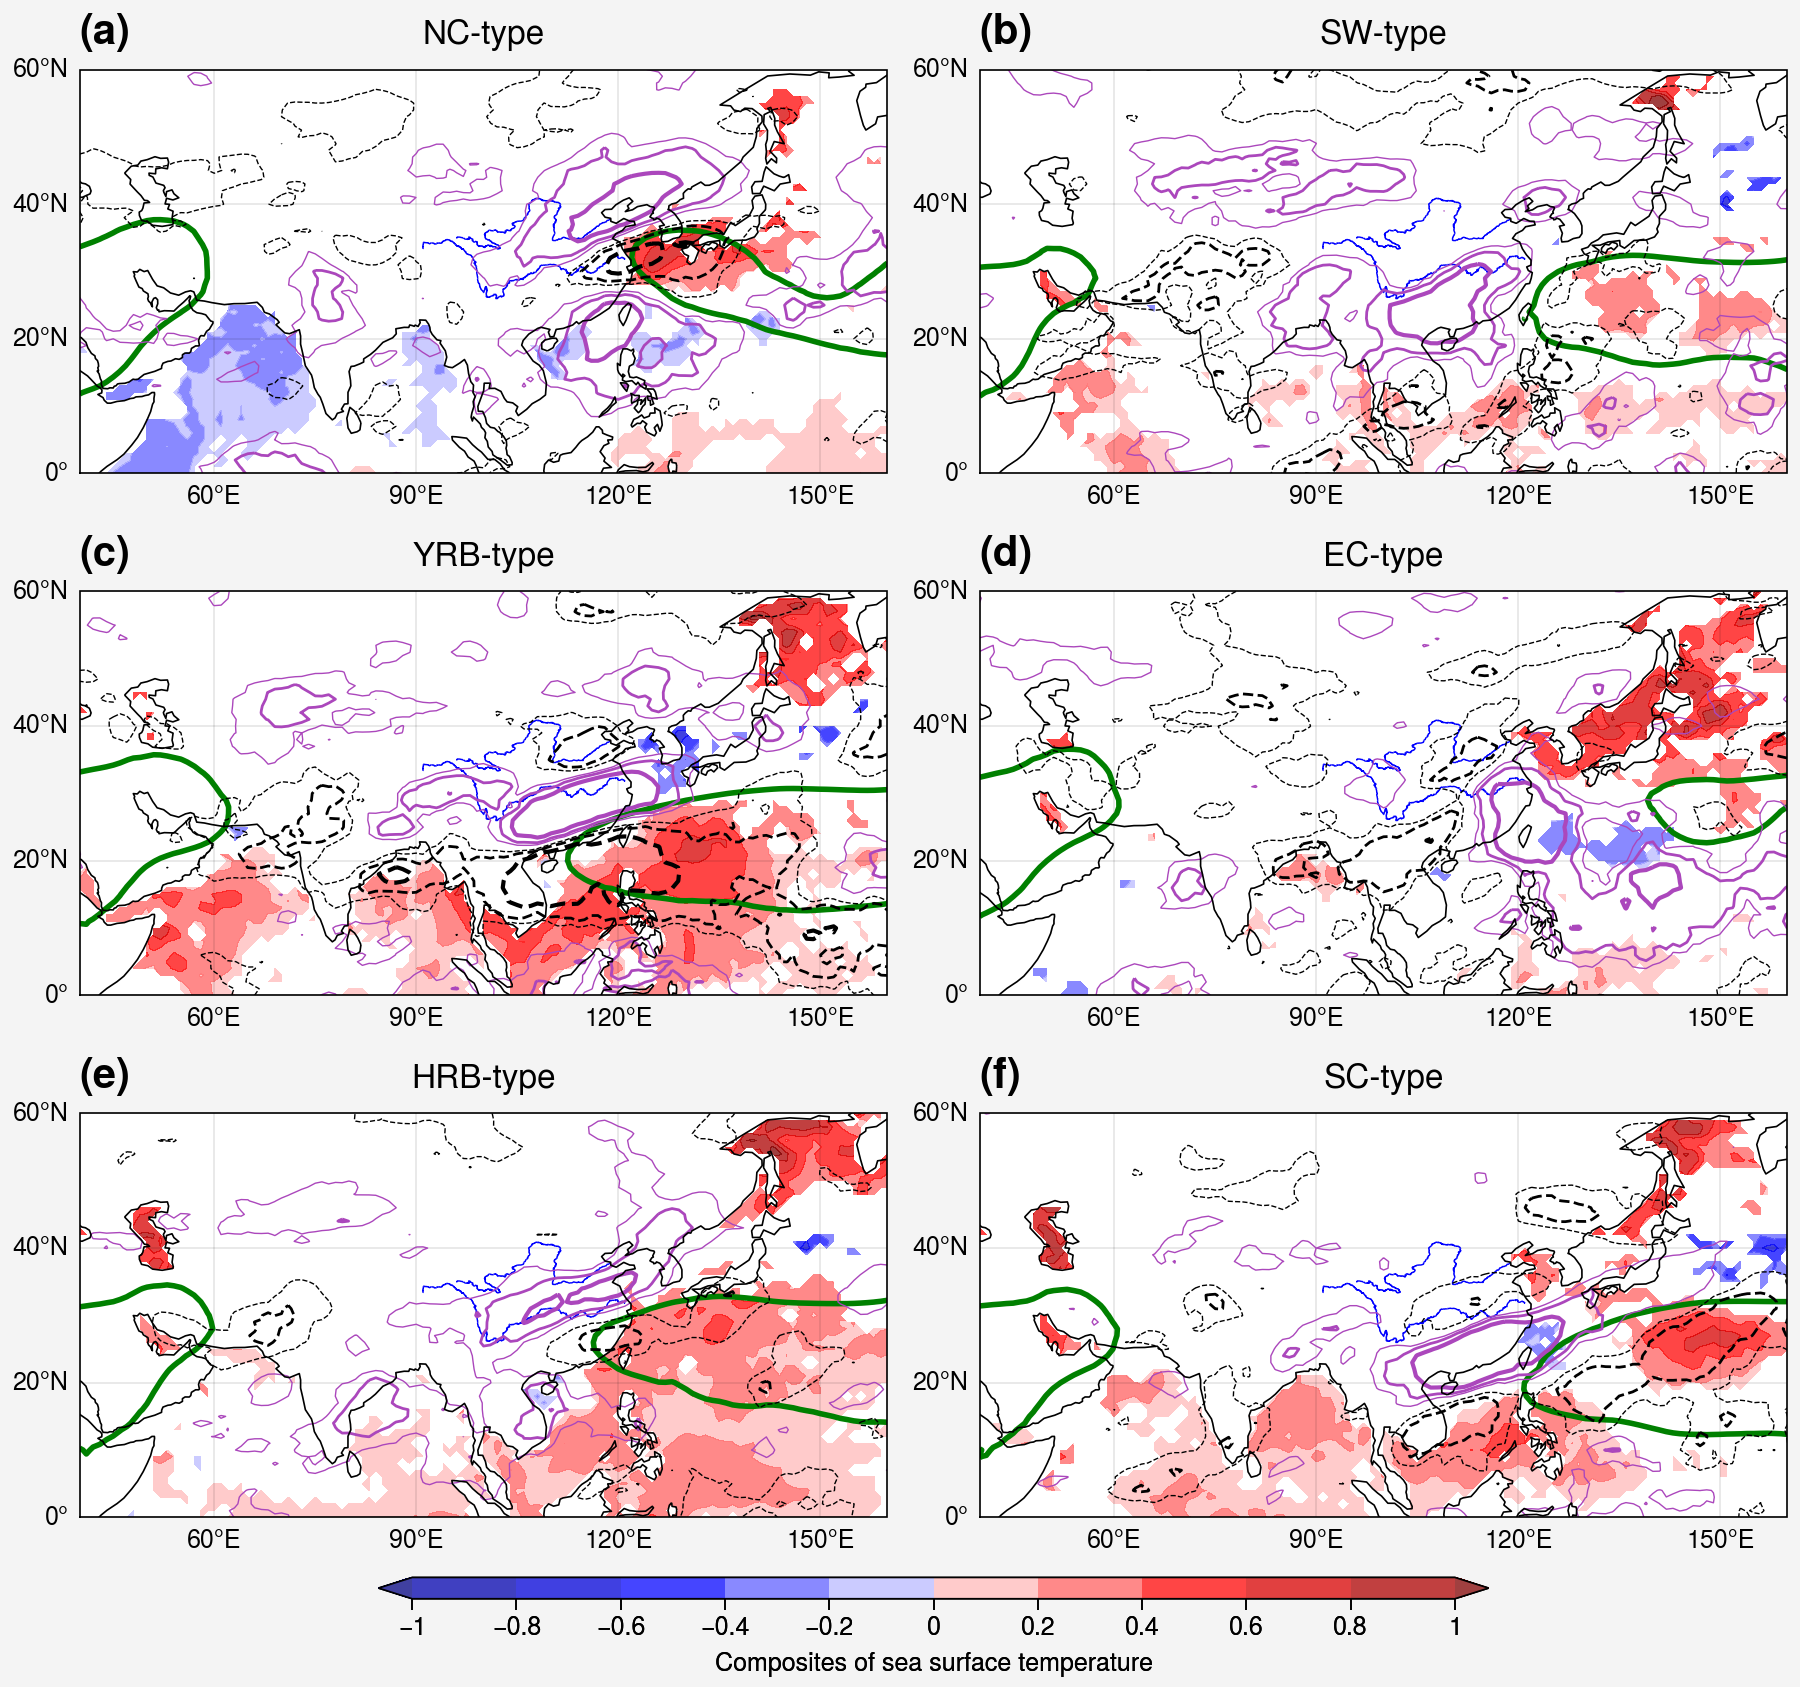

In [25]:
proj = pplt.Proj('pcarree', lon_0=180)
fig, ax = pplt.subplots(ncols=2,nrows=3,width = 9,proj=proj,share=False)

lon = GPH500_ano.coords['lon']
lat = GPH500_ano.coords['lat']
levels_sst = [i for i in np.linspace(-1,1,11)]
cmap1 = cmaps.BlRe
# cmap1 = cmaps.MPL_bwr
lon_min = 40
lon_max = 160
lat_min = -20
lat_max = 60

title_list = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

for i in range(6):
    ano_date_i = pd.to_datetime(winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==i]['Date'],format='%Y-%m-%d')
    ano_date_i.index = ano_date_i
    sst_ano_i = sst_ano.sel(time=ano_date_i.index)
    sst_ano_i_mean = sst_ano_i.mean(axis=0)
    olr_ano_i = olr_ano.sel(time=ano_date_i.index)
    olr_ano_i_mean = olr_ano_i.mean(axis=0)

    GPH500_i = GPH500.sel(time=ano_date_i.index)
    GPH500_i_mean = GPH500_i.mean(axis=0)

    sig_sst = xr.apply_ufunc(   ## determine the significance by t-test
        ttest,
        sst_ano,
        vectorize=True,
        dask='parallelized', 
        input_core_dims=[['time']],
        output_core_dims=[[]],
        kwargs={'pattern':i}
        )

    sig_sst = sig_sst < 0.05
    sst_ano_i_mean = sst_ano_i_mean * sig_sst
    sst_ano_i_mean = np.where(sst_ano_i_mean==0,np.nan,sst_ano_i_mean)

    river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.5)
    p1 = ax[i].contourf(lon,lat,sst_ano_i_mean,levels=levels_sst,alpha=0.75,extend='both',cmap=cmap1)
    ax[i].contour(lon,lat,GPH500_i_mean,levels=[5870],colors=('green',),linestyles=('-',),linewidths=(2,))

    ax[i].contour(lon,lat,olr_ano_i_mean,levels=[-5],colors=('#AB47BC',),linestyles=('-',),linewidths=(0.5,))
    ax[i].contour(lon,lat,olr_ano_i_mean,levels=[-10],colors=('#AB47BC',),linestyles=('-',),linewidths=(1,))
    ax[i].contour(lon,lat,olr_ano_i_mean,levels=[-20],colors=('#AB47BC',),linestyles=('-',),linewidths=(1.5,))

    ax[i].contour(lon,lat,olr_ano_i_mean,levels=[5],colors=('black',),linestyles=('--',),linewidths=(0.5,))
    ax[i].contour(lon,lat,olr_ano_i_mean,levels=[10],colors=('black',),linestyles=('--',),linewidths=(1,))
    ax[i].contour(lon,lat,olr_ano_i_mean,levels=[20],colors=('black',),linestyles=('--',),linewidths=(1.5,))

    ax[i].format(coast=True, lonlim=(lon_min,lon_max), latlim=(0,lat_max),labels=True, lonlines=30, latlines=20)
    ax[i].add_feature(river_feature)
    ax[i].set_title(title_list[i],fontdict={'fontsize':12})

ax.format(abc = '(a)', abcloc='l', abcsize=15,)
cbar = fig.colorbar(p1,loc='b',width='0.85em',length=0.65,)   
cbar.set_label(label='Composites of sea surface temperature',size='large',weight='bold') 

fig_dir = 'figure/'
fig.savefig(fig_dir + "sea_surface_temperature_anomalies1.pdf")

### 200 hpa zonal wind anomalies

In [56]:
uwind200 = xr.open_dataarray('dataset/era5/uwind_x40-160_y-20-60_t1961-2018_level200.nc')
uwind200 = uwind200.rename({'longitude':'lon','latitude':'lat'})
uwind200_ano = uwind200.groupby('time.dayofyear') - uwind200.groupby('time.dayofyear').mean()

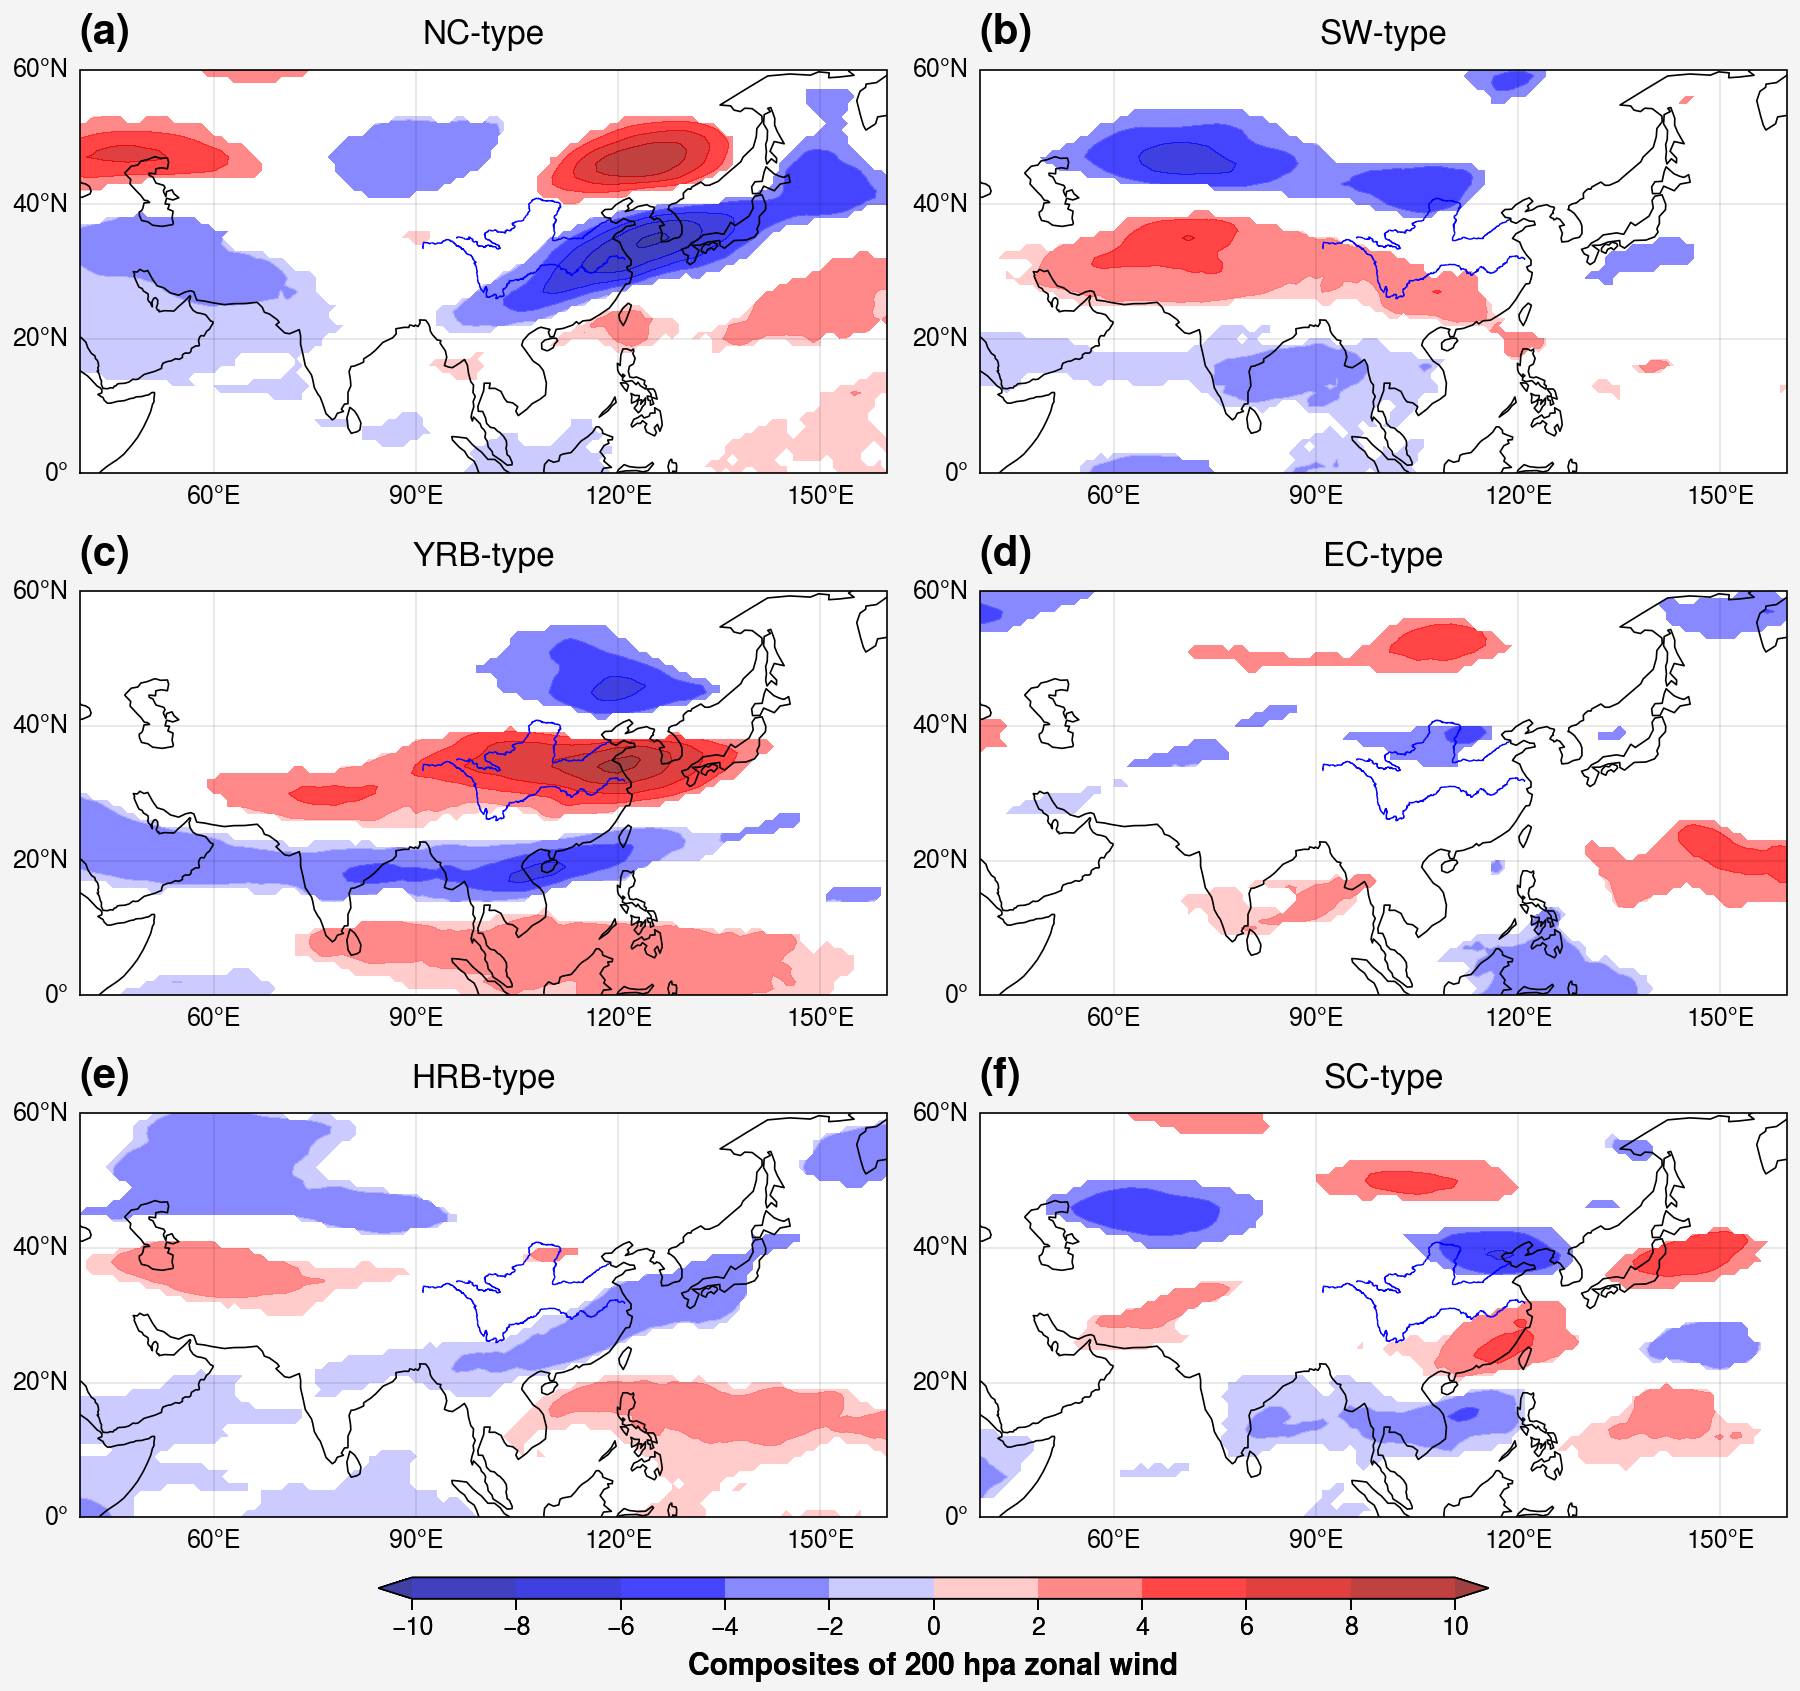

In [57]:
proj = pplt.Proj('pcarree', lon_0=180)
fig, ax = pplt.subplots(ncols=2,nrows=3,width = 9,proj=proj,share=False)

lon = GPH500_ano.coords['lon']
lat = GPH500_ano.coords['lat']
levels_uwind_200 = [i for i in np.linspace(-10,10,11)]
cmap1 = cmaps.BlRe
# cmap1 = cmaps.MPL_bwr
lon_min = 40
lon_max = 160
lat_min = -20
lat_max = 60

title_list = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

for i in range(6):
    ano_date_i = pd.to_datetime(winner_dist_with_nan[winner_dist_with_nan['Som_pattern']==i]['Date'],format='%Y-%m-%d')
    ano_date_i.index = ano_date_i
    uwind200_ano_i = uwind200_ano.sel(time=ano_date_i.index)
    uwind200_ano_i_mean = uwind200_ano_i.mean(axis=0)

    sig_uwind = xr.apply_ufunc(   ## determine the significance by t-test
        ttest,
        uwind200_ano,
        vectorize=True,
        dask='parallelized', 
        input_core_dims=[['time']],
        output_core_dims=[[]],
        kwargs={'pattern':i}
        )

    sig_uwind = sig_uwind < 0.05
    uwind200_ano_i_mean = uwind200_ano_i_mean * sig_uwind
    uwind200_ano_i_mean = np.where(uwind200_ano_i_mean==0,np.nan,uwind200_ano_i_mean)

    river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.5)
    p1 = ax[i].contourf(lon,lat,uwind200_ano_i_mean,levels=levels_uwind_200,alpha=0.75,extend='both',cmap=cmap1)
    # ax[i].contour(lon,lat,GPH500_i_mean,levels=[5870],colors=('green',),linestyles=('-',),linewidths=(2,))

    ax[i].format(coast=True, lonlim=(lon_min,lon_max), latlim=(0,lat_max),labels=True, lonlines=30, latlines=20)
    ax[i].add_feature(river_feature)
    ax[i].set_title(title_list[i],fontdict={'fontsize':12})

ax.format(abc = '(a)', abcloc='l', abcsize=15,)
cbar = fig.colorbar(p1,loc='b',width='0.85em',length=0.65,)
cbar.set_label(label='Composites of 200 hpa zonal wind',size='large',weight='bold')

fig_dir = 'figure/'
fig.savefig(fig_dir + "200hpa_vwind_anomalies.pdf")
